In [1]:
import findspark

findspark.init()

In [2]:
import pyspark
from pyspark.sql import SparkSession


spark = SparkSession.builder.getOrCreate()

### Data Screening

In [3]:
df = spark.read.csv('data/banking.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: integer (nullable = true)



In [4]:
import pandas as pd


# get data statistics
df = df.withColumnRenamed('y', 'label')
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int' or t[1] == 'double']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,41188,40.02406040594348,10.421249980934071,17,98
duration,41188,258.2850101971448,259.2792488364657,0,4918
campaign,41188,2.567592502670681,2.7700135429023445,1,56
pdays,41188,962.4754540157328,186.91090734474153,0,999
previous,41188,0.17296299893172767,0.49490107983929027,0,7
emp_var_rate,41188,0.0818855006312578,1.5709597405170233,-3.4,1.4
cons_price_idx,41188,93.57566436827008,0.5788400489541244,92.201,94.767
cons_conf_idx,41188,-40.50260027192037,4.628197856174547,-50.8,-26.9
euribor3m,41188,3.621290812858366,1.734447404851269,0.634,5.045


In [5]:
import seaborn as sns


#plot correlations in numeric features
plot = sns.pairplot(df.select(numeric_features).toPandas())
plot.savefig("out/correlations.png")

In [6]:
df = df.drop('month')
df = df.drop('day_of_week')

### Assemble Feature Vector

In [7]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler


categoricalColumns = ['job',\
                      'marital',\
                      'education',\
                      'default',\
                      'housing',\
                      'loan',\
                      'contact',\
                      'poutcome']
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]


numericCols = ['age',\
               'duration',\
               'campaign',\
               'pdays',\
               'previous',\
               'emp_var_rate',\
               'cons_price_idx',\
               'cons_conf_idx',\
               'euribor3m',\
               'nr_employed']
# numericCols = ['age', 'duration', 'campaign', 'pdays', 'previous']
numericCols = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate']

assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

### Build Pipeline

In [8]:
from pyspark.ml import Pipeline


cols = df.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- label: integer (nullable = true)



### Split in Train and Test

In [9]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 28839
Test Dataset Count: 12349


### Logistic Regression

In [10]:
from pyspark.ml.classification import LogisticRegression


lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

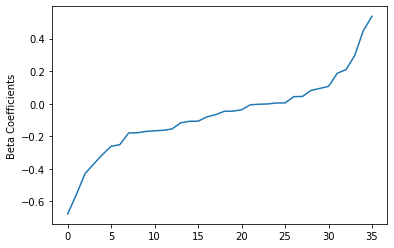

In [25]:
import matplotlib.pyplot as plt
import numpy as np


beta = np.sort(lrModel.coefficients)

plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.savefig("out/coefficients.png")
plt.show()


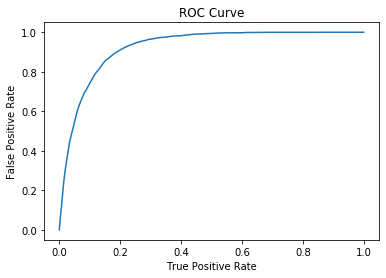

Training set areaUnderROC: 0.924036051455572


In [26]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.savefig("out/ROC.png")
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

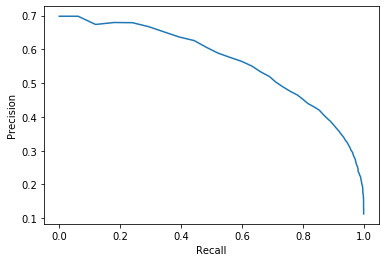

In [27]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.savefig("out/precision_recall.png")
plt.show()


In [14]:
predictions = lrModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+------+-----+--------------------+----------+--------------------+
|age|   job|label|       rawPrediction|prediction|         probability|
+---+------+-----+--------------------+----------+--------------------+
| 24|admin.|    0|[2.70505964014151...|       0.0|[0.93732454238592...|
| 26|admin.|    0|[3.63247846821648...|       0.0|[0.97423105637233...|
| 27|admin.|    1|[2.19693505987404...|       0.0|[0.89997394041070...|
| 28|admin.|    0|[2.38200018163966...|       0.0|[0.91544438895876...|
| 28|admin.|    1|[-0.2787543801017...|       1.0|[0.43075918279122...|
| 29|admin.|    0|[4.22071913522039...|       0.0|[0.98552453871257...|
| 29|admin.|    0|[2.33188414854880...|       0.0|[0.91148347030422...|
| 29|admin.|    1|[2.02065743605794...|       0.0|[0.8829489723047,...|
| 29|admin.|    1|[1.80055532349590...|       0.0|[0.85821652081855...|
| 29|admin.|    0|[3.54171883870912...|       0.0|[0.97185177057569...|
+---+------+-----+--------------------+----------+--------------

In [15]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator


evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9220948700413174


### Decision Tree

In [16]:
from pyspark.ml.classification import DecisionTreeClassifier


dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+------+-----+----------------+----------+--------------------+
|age|   job|label|   rawPrediction|prediction|         probability|
+---+------+-----+----------------+----------+--------------------+
| 24|admin.|    0|[23193.0,1203.0]|       0.0|[0.95068863748155...|
| 26|admin.|    0|[23193.0,1203.0]|       0.0|[0.95068863748155...|
| 27|admin.|    1|  [1221.0,560.0]|       0.0|[0.68556990454800...|
| 28|admin.|    0|[23193.0,1203.0]|       0.0|[0.95068863748155...|
| 28|admin.|    1|  [1221.0,560.0]|       0.0|[0.68556990454800...|
| 29|admin.|    0|[23193.0,1203.0]|       0.0|[0.95068863748155...|
| 29|admin.|    0|[23193.0,1203.0]|       0.0|[0.95068863748155...|
| 29|admin.|    1|[23193.0,1203.0]|       0.0|[0.95068863748155...|
| 29|admin.|    1|[23193.0,1203.0]|       0.0|[0.95068863748155...|
| 29|admin.|    0|[23193.0,1203.0]|       0.0|[0.95068863748155...|
+---+------+-----+----------------+----------+--------------------+
only showing top 10 rows



In [17]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.2454991333369376


### Random Forest

In [18]:
from pyspark.ml.classification import RandomForestClassifier


rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+------+-----+--------------------+----------+--------------------+
|age|   job|label|       rawPrediction|prediction|         probability|
+---+------+-----+--------------------+----------+--------------------+
| 24|admin.|    0|[18.8356642619449...|       0.0|[0.94178321309724...|
| 26|admin.|    0|[18.8647384434417...|       0.0|[0.94323692217208...|
| 27|admin.|    1|[16.6936897342582...|       0.0|[0.83468448671291...|
| 28|admin.|    0|[17.7858950066730...|       0.0|[0.88929475033365...|
| 28|admin.|    1|[13.4862645632260...|       0.0|[0.67431322816130...|
| 29|admin.|    0|[18.8647384434417...|       0.0|[0.94323692217208...|
| 29|admin.|    0|[17.7858950066730...|       0.0|[0.88929475033365...|
| 29|admin.|    1|[17.4465022654759...|       0.0|[0.87232511327379...|
| 29|admin.|    1|[17.4465022654759...|       0.0|[0.87232511327379...|
| 29|admin.|    0|[18.8356642619449...|       0.0|[0.94178321309724...|
+---+------+-----+--------------------+----------+--------------

In [19]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9095151343429695


### Gradient-Boosted Tree

In [20]:
from pyspark.ml.classification import GBTClassifier


gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+------+-----+--------------------+----------+--------------------+
|age|   job|label|       rawPrediction|prediction|         probability|
+---+------+-----+--------------------+----------+--------------------+
| 24|admin.|    0|[1.11040666224876...|       0.0|[0.90210304643682...|
| 26|admin.|    0|[1.31274987123453...|       0.0|[0.93248477790623...|
| 27|admin.|    1|[0.56351912397343...|       0.0|[0.75529190416940...|
| 28|admin.|    0|[1.24610824913378...|       0.0|[0.92359436301908...|
| 28|admin.|    1|[-0.0301080596922...|       1.0|[0.48495051730731...|
| 29|admin.|    0|[1.31274987123453...|       0.0|[0.93248477790623...|
| 29|admin.|    0|[1.23924604511628...|       0.0|[0.92262021351630...|
| 29|admin.|    1|[0.67888594495898...|       0.0|[0.79539733280521...|
| 29|admin.|    1|[0.58084867695289...|       0.0|[0.76164099607487...|
| 29|admin.|    0|[1.30713058809679...|       0.0|[0.93177378411529...|
+---+------+-----+--------------------+----------+--------------

In [21]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9307625201143834


In [22]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

Params = (maxDepth=5, maxBins=32 , maxIter= 10)

### Tune Params using Grid Search

In [23]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.9349856362945885

In [24]:
cvModel.explainParams()

"estimator: estimator to be cross-validated (current: GBTClassifier_b5450e1cdfd0)\nestimatorParamMaps: estimator param maps (current: [{Param(parent='GBTClassifier_b5450e1cdfd0', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2, Param(parent='GBTClassifier_b5450e1cdfd0', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 20, Param(parent='GBTClassifier_b5450e1cdfd0', name='maxIter', doc='max number of iterations (>= 0).'): 10}, {Param(parent='GBTClassifier_b5450e1cdfd0', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2, Param(parent='GBTClassifier_b5450e1cdfd0', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.')

### Conclusion

Gradient-Boosted Tree (using Params maxBins=20, maxIter=20, maxDepth=2) performed best, directly followed by logistic regression. 